In [ ]:
import numpy as np

In [ ]:
class LinearMultiClassification :
  def __init__ (self,class_num=1) :
    self.weight = None
    self.bias = None
    self.class_num = class_num
    self.grad_weight = None
    self.grad_bias = None
    self.xhist = None


  def __build_weight (self,features) :
    std_values = np.sqrt(6/(features + 1))
    self.weight = np.random.uniform(
        low=-std_values,high=std_values,size=(features,self.class_num)
    )
    self.bias = np.zeros((1,self.class_num))

  def __call__ (self,x) :
    self.xhist = x
    if self.weight is None or self.bias is None :
      self.__build_weight(x.shape[-1])
    return np.matmul(x,self.weight) + self.bias

  def backwardpass (self,grad) :
    self.grad_weight  = np.matmul(self.xhist.T,grad)
    self.grad_bias = np.sum(grad,axis=0,keepdims=True)

  def get_weight(self) :
    return [self.weight,self.bias]

  def update_weight (self,w) :
    self.weight = w

  def update_bias (self,b) :
    self.bias = b

  def get_grad (self) :
    return [self.grad_weight,self.grad_bias]


In [ ]:
def softmax(x) :
  xmax = np.max(x,axis=-1,keepdims=True)
  xexp = np.exp(x-xmax)
  xsum = np.sum(xexp,axis=-1,keepdims=True)
  xsum[xsum==0]= 1e-6
  return xexp / xsum

In [ ]:
class SparseCategoricallCrossentropy :
  def __call__ (self,y_true,y_pred) :
    y_pred = softmax(y_pred)
    label_true = np.arange(len(y_true))
    self.cache = y_pred.copy(),label_true.copy(),y_true.copy()
    los = -np.log(y_pred[label_true,y_true])
    return np.mean(los)


  def backwardpass(self) :
    y_pred,label_indexTrue,y_cache = self.cache
    grad = y_pred
    grad[label_indexTrue,y_cache] =- 1
    grad /= len(y_cache)
    return grad

class RMSProp :
  def __init__(self,lr= 1e-3,beta = 0.999,clipnorm = 0) :
    self.lr = lr
    self.beta = beta
    self.RMS = None
    self.Model_weight = None
    self.grad = None
    self.epoch = 0
    self.clipnorm = clipnorm

  def apply_weight(self,weight:list) :
    self.Model_weight = weight

  def apply_grad (self,grad : list):
    self.grad = grad

  def build_Component (self) :
    self.RMS = list()
    for w in self.Model_weight :
      self.RMS.append(np.zeros_like(w))

  def __execute (self,w,g,r) :
    rms = self.beta * r + (1 - self.beta) * np.power(g,2)
    rms_hat = rms / (1 - self.beta ** (self.epoch + 1))
    w -= self.lr / np.sqrt(rms_hat + 1e-6) * g
    return w,rms

  def step(self) :
    if self.RMS is None :
      self.build_Component()
    for i in range(len(self.Model_weight)) :
      w,r = self.__execute(
        w = self.Model_weight[i],
        g = self.grad[i],
        r= self.RMS[i]
      )
      self.Model_weight[i]  = w
      self.RMS[i] = r
    self.epoch +=1
    return self.Model_weight

In [ ]:
from sklearn.datasets import make_classification
x_train,y_train = make_classification(n_samples=500,n_features=50,n_informative=20,n_classes=4)

In [ ]:
linear = LinearMultiClassification(class_num=4)
loss_fn = SparseCategoricallCrossentropy()
optimizer = RMSProp(lr=1e-3,clipnorm=1.5)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
history = list()
epochs = 500
accuray_hist = list()
for epoch in range(epochs) :
  y_pred = linear(x_train.copy())
  loss = loss_fn(y_train,y_pred)
  gradloss = loss_fn.backwardpass()
  accuray_hist.append(np.mean(np.argmax(y_pred,axis=-1) == y_train))
  linear.backwardpass(gradloss)
  optimizer.apply_weight(linear.get_weight())
  optimizer.apply_grad(linear.get_grad())
  weight = optimizer.step()
  linear.update_weight(weight[0])
  linear.update_bias(weight[1])
  print(f"epoch : {epoch + 1}/{epochs }loss : {loss}")
  history.append(loss)

epoch : 1/500loss : 2.7922741587503928
epoch : 2/500loss : 2.77383614337235
epoch : 3/500loss : 2.755664285051701
epoch : 4/500loss : 2.7376039404646875
epoch : 5/500loss : 2.7197460093660975
epoch : 6/500loss : 2.702025940303708
epoch : 7/500loss : 2.684493210434739
epoch : 8/500loss : 2.667097494944855
epoch : 9/500loss : 2.649887009141284
epoch : 10/500loss : 2.6328050792035946
epoch : 11/500loss : 2.6159145029673208
epoch : 12/500loss : 2.5991366047026547
epoch : 13/500loss : 2.582566698426773
epoch : 14/500loss : 2.566082959102731
epoch : 15/500loss : 2.549836796481139
epoch : 16/500loss : 2.533640550607155
epoch : 17/500loss : 2.517715875654463
epoch : 18/500loss : 2.5018128892858726
epoch : 19/500loss : 2.486195166620025
epoch : 20/500loss : 2.470600507283847
epoch : 21/500loss : 2.455275574427507
epoch : 22/500loss : 2.439996510973263
epoch : 23/500loss : 2.4249610648609923
epoch : 24/500loss : 2.4099956229884345
epoch : 25/500loss : 2.395251921533381
epoch : 26/500loss : 2.380

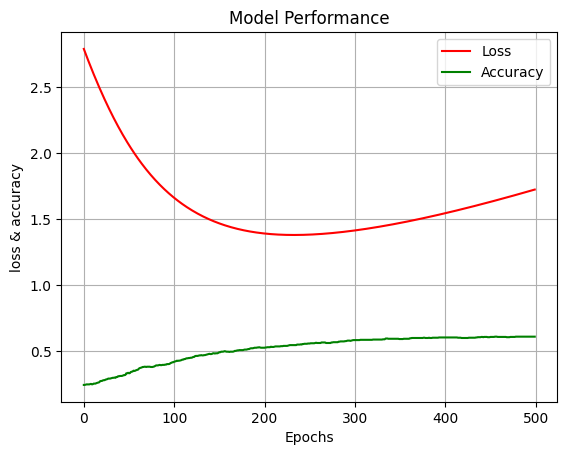

In [ ]:
plt.title("Model Performance")
plt.plot(history,label="Loss",color='red')
plt.plot(accuray_hist,label="Accuracy",color='green')
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("loss & accuracy")
plt.legend()
plt.show()